# Testing it with various models

## Import all the things we need

In [1]:
# setup the matplotlib graphics library and configure it to show 
# figures inline in the notebook
%matplotlib inline
from qutip import*
from scipy import *
import QCLSolver.data as QCLData
import QCLSolver.solver as QCLS
import numpy as np
import matplotlib.pyplot as plt
import time

In [2]:
  def randomcolor():
        "get random color"
        colorArr = ['1','2','3','4','5','6','7','8','9','A','B','C','D','E','F']
        color = ""
        for i in range(6):
            color += colorArr[np.random.randint(0,14)]
        return "#"+color

In [3]:
def squareError(a,b):
    return np.real(np.sqrt(np.sum(np.power(a-b,2)))/len(a))

In [4]:
def reError(a,b):
    return np.real(np.sqrt(np.power((a-b)/a,2)))

## Testing it in Jaynes-Cumming model

With the rotating-wave approximation

$$H_{\rm RWA} = \hbar \omega_c a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g(a^\dagger\sigma_- + a\sigma_+)$$

### Build up the qutip version

In [5]:
wc = 1.0  * 2 * pi  # cavity frequency
wa = 1.0  * 2 * pi  # atom frequency
g  = 0.05 * 2 * pi  # coupling strength
kappa = 0.005       # cavity dissipation rate
gamma = 0.05        # atom dissipation rate
N = 15              # number of cavity fock states
n_th_a = 0.0        # avg number of thermal bath excitation

tlist = np.linspace(0,25,101)

In [6]:
# intial state
psi0 = tensor(basis(N,0), basis(2,1))    # start with an excited atom

# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))
 #Hamiltonian
H = wc * a.dag() * a + wa * sm.dag() * sm + g * (a.dag() * sm + a * sm.dag())


In [7]:
c_ops = []

# cavity relaxation
rate1 = kappa * (1 + n_th_a)
c_ops.append(np.sqrt(rate1) * a)


rate2= kappa * n_th_a
c_ops.append(np.sqrt(rate2) * a.dag())

# qubit relaxation
rate3 = gamma
c_ops.append(np.sqrt(rate3) * sm)

In [8]:
tic=time.time()
output = mesolve(H, psi0, tlist, c_ops, [a.dag() * a, sm.dag() * sm])
toc=time.time()
t_qutip=toc-tic

In [9]:
n_c = output.expect[0]
n_a = output.expect[1]

### Build up the QCLS version

In [10]:
Hamilton=[['Aa',wc],['Bb',wa],['Ab',g],['aB',g]];print(Hamilton)
Co_ps=[['a',rate1],['A',rate2],['b',rate3]];print(Co_ps)
T_o=['Aa','Bb'];print(T_o)

[['Aa', 6.283185307179586], ['Bb', 6.283185307179586], ['Ab', 0.3141592653589793], ['aB', 0.3141592653589793]]
[['a', 0.005], ['A', 0.0], ['b', 0.05]]
['Aa', 'Bb']


In [11]:
data=QCLData.Data(Hamilton,Co_ps, T_o, 2)

In [12]:
tic=time.time()
sol2=QCLS.Solve(data, [0,1], (0,25), t_eval=tlist)
toc=time.time()
t_cluster=toc-tic

Cavity Square Error:4.957290848913662e-05
Atom Square Error:4.951730633682543e-05


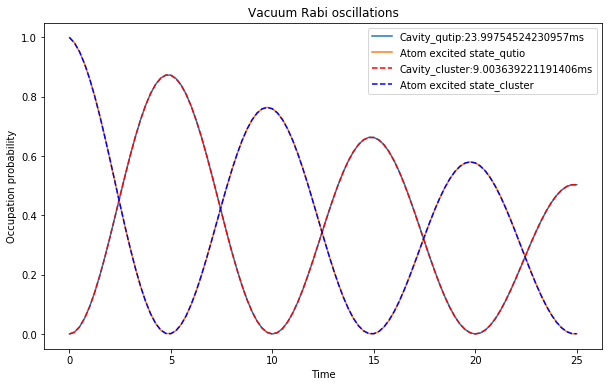

In [17]:
fig1, axes1 = plt.subplots(1, 1, figsize=(10,6))

axes1.plot(tlist, n_c,label="Cavity_qutip:"+str(1000*t_qutip)+'ms')
axes1.plot(tlist, n_a,label="Atom excited state_qutio")
axes1.plot(tlist, np.real(sol2.y[0]),color='red',linestyle='--',label="Cavity_cluster:"+str(1000*t_cluster)+'ms')
axes1.plot(tlist, np.real(sol2.y[1]),color='blue',linestyle='--',label="Atom excited state_cluster")
axes1.legend(loc=0)
axes1.set_xlabel('Time')
axes1.set_ylabel('Occupation probability')
axes1.set_title('Vacuum Rabi oscillations')
print("Cavity Square Error:"+str(squareError(n_c,sol2.y[0])))
print("Atom Square Error:"+str(squareError(n_a,sol2.y[1])))

##  simulation of a two-qubit gate using a resonator as coupler

### Build up the qutip version

In [18]:
N = 15

wc = 5.0 * 2 * pi
w1 = 3.0 * 2 * pi
w2 = 2.0 * 2 * pi

g1 = 0.01 * 2 * pi
g2 = 0.0125 * 2 * pi

tlist = np.linspace(0, 100, 500)

width = 0.5

# resonant SQRT iSWAP gate
T0_1 = 20
T_gate_1 = (1*pi)/(4 * g1)

# resonant iSWAP gate
T0_2 = 60
T_gate_2 = (2*pi)/(4 * g2)

In [19]:
# cavity operators
a = tensor(destroy(N), qeye(2), qeye(2))
n = a.dag() * a

# operators for qubit 1

sm1 = tensor(qeye(N), destroy(2), qeye(2))
n1 = sm1.dag() * sm1
sz1 = tensor(qeye(N), sigmaz(), qeye(2))


# oeprators for qubit 2
sm2 = tensor(qeye(N), qeye(2), destroy(2))
n2 = sm2.dag() * sm2
sz2 = tensor(qeye(N), qeye(2), sigmaz())


In [20]:
# Hamiltonian using QuTiP
Hc = a.dag() * a
H1 = - 0.5 * sz1
H2 = - 0.5 * sz2
Hc1 = g1 * (a.dag() * sm1 + a * sm1.dag())
Hc2 = g2 * (a.dag() * sm2 + a * sm2.dag())

H = wc * Hc + w1 * H1 + w2 * H2 + Hc1 + Hc2 

In [21]:
# initial state: start with one of the qubits in its excited state
psi0 = tensor(basis(N,0),basis(2,1),basis(2,0))

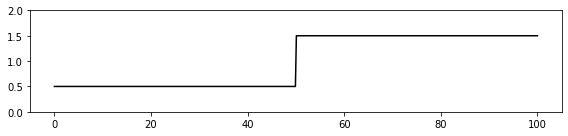

In [22]:
def step_t(w1, w2, t0, width, t):
    """
    Step function that goes from w1 to w2 at time t0
    as a function of t. 
    """
    return w1 + (w2 - w1) * (t > t0)


fig, axes = plt.subplots(1, 1, figsize=(8,2))
axes.plot(tlist, [step_t(0.5, 1.5, 50, 0.0, t) for t in tlist], 'k')
axes.set_ylim(0, 2)
fig.tight_layout()

In [23]:
def wc_t(t,args=None):
    return wc

def w1_t(t,args=None):
    return w1 + step_t(0.0, wc-w1, T0_1, width, t) - step_t(0.0, wc-w1, T0_1+T_gate_1, width, t)

def w2_t(t,args=None):
    return w2 + step_t(0.0, wc-w2, T0_2, width, t) - step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)


H_t = [[Hc, wc_t], [H1, w1_t], [H2, w2_t], Hc1+Hc2]

In [24]:
tic=time.time()
output = mesolve(H_t, psi0, tlist, [], [n,n1,n2])
toc=time.time()
t_qutip=toc-tic

### Build up the QCLS version

In [25]:
Hc='Aa'
H1='Bb'
H2='Cc'
Hc1_1='Ab'
Hc1_2='aB'
Hc2_1='Ac'
Hc2_2='aC'
T_o=['Aa','Bb','Cc']

def wc_tc(t):
    return wc

def w1_tc(t):
    return w1 + step_t(0.0, wc-w1, T0_1, width, t) - step_t(0.0, wc-w1, T0_1+T_gate_1, width, t)

def w2_tc(t):
    return w2 + step_t(0.0, wc-w2, T0_2, width, t) - step_t(0.0, wc-w2, T0_2+T_gate_2, width, t)


In [26]:
H_t=[[Hc,wc_tc],[H1,w1_tc],[H2,w2_tc],[Hc1_1,g1],[Hc1_2,g1],[Hc2_1,g2],[Hc2_2,g2]]
print(H_t)

[['Aa', <function wc_tc at 0x000002462B6A1558>], ['Bb', <function w1_tc at 0x000002462B6A1318>], ['Cc', <function w2_tc at 0x000002462B6A1678>], ['Ab', 0.06283185307179587], ['aB', 0.06283185307179587], ['Ac', 0.07853981633974483], ['aC', 0.07853981633974483]]


In [27]:
data=QCLData.Data(H_t, [], T_o, 2)

In [28]:
tic=time.time()
sol2=QCLS.Solve(data, [0,1,0], (0,100), t_eval=tlist)
toc=time.time()
t_cluster=toc-tic

Cavity Square Error:3.203746150511421e-05
Qubit 1 Square Error:3.65626736642017e-05
Qubit 2 Square Error:1.8348400146474723e-05


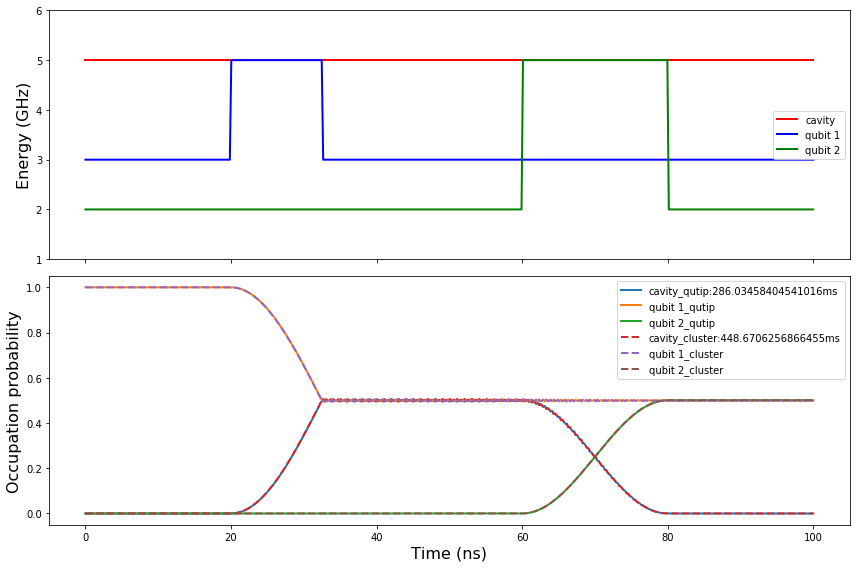

In [29]:
fig, axes = plt.subplots(2, 1, sharex=True, figsize=(12,8))

axes[0].plot(tlist, np.array(list(map(wc_t, tlist))) / (2*pi), 'r', linewidth=2, label="cavity")
axes[0].plot(tlist, np.array(list(map(w1_t, tlist))) / (2*pi), 'b', linewidth=2, label="qubit 1")
axes[0].plot(tlist, np.array(list(map(w2_t, tlist))) / (2*pi), 'g', linewidth=2, label="qubit 2")
axes[0].set_ylim(1, 6)
axes[0].set_ylabel("Energy (GHz)", fontsize=16)
axes[0].legend()

axes[1].plot(tlist, np.real(output.expect[0]), linewidth=2, label="cavity_qutip:"+str(1000*t_qutip)+'ms')
axes[1].plot(tlist, np.real(output.expect[1]), linewidth=2, label="qubit 1_qutip")
axes[1].plot(tlist, np.real(output.expect[2]), linewidth=2, label="qubit 2_qutip")
axes[1].plot(tlist, np.real(sol2.y[0]), linestyle='--',linewidth=2, label="cavity_cluster:"+str(1000*t_cluster)+'ms')
axes[1].plot(tlist, np.real(sol2.y[1]), linestyle='--',linewidth=2, label="qubit 1_cluster")
axes[1].plot(tlist, np.real(sol2.y[2]), linestyle='--',linewidth=2, label="qubit 2_cluster")

axes[1].set_xlabel("Time (ns)", fontsize=16)
axes[1].set_ylabel("Occupation probability", fontsize=16)
axes[1].legend()

fig.tight_layout()
print("Cavity Square Error:"+str(squareError(output.expect[0],sol2.y[0])))
print("Qubit 1 Square Error:"+str(squareError(output.expect[1],sol2.y[1])))
print("Qubit 2 Square Error:"+str(squareError(output.expect[2],sol2.y[2])))

## Single-Atom-Lasing

The coherent dynamics in this model is described by the Hamiltonian
$$H = \hbar \omega_0 a^\dagger a + \frac{1}{2}\hbar\omega_a\sigma_z + \hbar g\sigma_x(a^\dagger + a)$$

### Build up the qutip version

In [6]:
w0 = 1.0  * 2 * pi  # cavity frequency
wa = 1  * 2 * pi  # atom frequency
g  = 0.05 * 2 * pi  # coupling strength

kappa = 0.04        # cavity dissipation rate
gamma = 0.00        # atom dissipation rate
Gamma = 0.35        # atom pump rate

N = 50              # number of cavity fock states
n_th_a = 0.0        # avg number of thermal bath excitation

tlist = np.linspace(0, 150, 101)

In [7]:
# intial state
psi0 = tensor(basis(N,0), basis(2,0)) # start without excitations

# operators
a  = tensor(destroy(N), qeye(2))
sm = tensor(qeye(N), destroy(2))
sx = tensor(qeye(N), sigmax())
sz=tensor(qeye(N),sigmaz())

# Hamiltonian
#H = w0 * a.dag() * a +wa * sm.dag() * sm + g * (a.dag() + a) * sx
#H = w0 * a.dag() * a +wa * sm.dag()*sm + g * (a.dag() + a) * (sm.dag()+sm)
#H = w0 * a.dag() * a +wa * sm.dag()*sm + g * a.dag()*sm.dag()+\
#g*a.dag()*sm+g*a*sm+g*a*sm.dag()
H = w0 * a.dag() * a +wa * sm.dag()*sm + g * a.dag()*sm+g*sm.dag()*a

In [8]:
# collapse operators
c_ops = []

rate1 = kappa * (1 + n_th_a)
c_ops.append(np.sqrt(rate1) * a)

rate2= kappa * n_th_a
c_ops.append(np.sqrt(rate2) * a.dag())

rate3 = gamma
c_ops.append(np.sqrt(rate3) * sm)

rate4 = Gamma
c_ops.append(np.sqrt(rate4) * sm.dag())

In [9]:
opt = Odeoptions(nsteps=2000) # allow extra time-steps 
tic=time.time()
output = mesolve(H, psi0, tlist,c_ops, [a.dag() * a, sm.dag() * sm], options=opt)
toc=time.time()
t_qutip=toc-tic

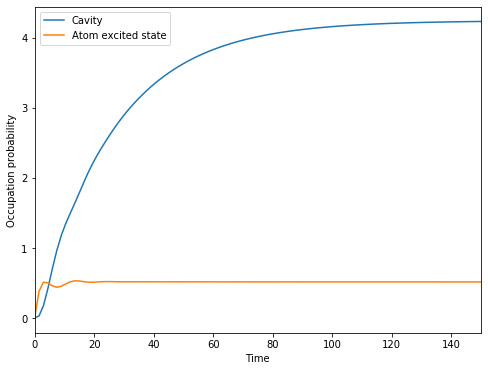

In [10]:
n_c = output.expect[0]
n_a = output.expect[1]

fig, axes = plt.subplots(1, 1, figsize=(8,6))

axes.plot(tlist, n_c, label="Cavity")
axes.plot(tlist, n_a, label="Atom excited state")
axes.set_xlim(0, 150)
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability');

### Build up the QCLS version

In [22]:
Hc='Aa';Ha='Bb';
H1_1='Ab';
H2_1='aB';
H=[[Hc,w0],[Ha,wa],[H1_1,g],[H2_1,g]]
print(H)
Co_ps=[['a',rate1],['B',rate4]]
print(Co_ps)
T_o=['Aa','Bb']

[['Aa', 6.283185307179586], ['Bb', 6.283185307179586], ['Ab', 0.3141592653589793], ['aB', 0.3141592653589793]]
[['a', 0.04], ['B', 0.35]]


In [23]:
data=QCLData.Data(H,Co_ps, T_o, 3)
data.Debug()

In [24]:
tic=time.time()
sol2=QCLS.Solve(data, [0,0], (0,150), t_eval=tlist,atol=1e-10,rtol=1e-8)
toc=time.time()
t_cluster=toc-tic
np.shape(tlist)

(101,)

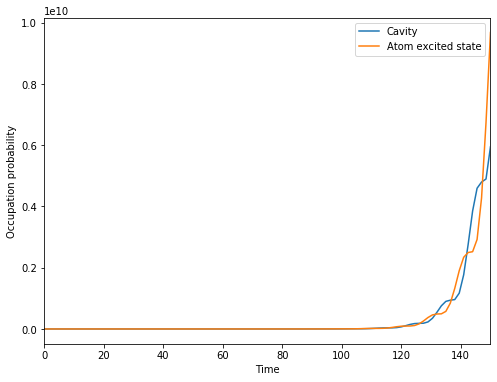

In [25]:
fig, axes = plt.subplots(1, 1, figsize=(8,6))

axes.plot(sol2.t, np.real(sol2.y[0]), label="Cavity")
axes.plot(sol2.t, np.real(sol2.y[1]), label="Atom excited state")
axes.set_xlim(0, 150)
axes.legend(loc=0)
axes.set_xlabel('Time')
axes.set_ylabel('Occupation probability');

FAIL!

## Cavity-enhanced second-harmonic generation 

The Hamiltonian of the model is descrided as
$$
H_{rot}=\hbar\Delta_{a}a^{\dagger}a+\hbar\Delta_{b}b^{\dagger}b+\hbar g_{nl}[b(a^{\dagger}])^2+b^{\dagger}a^2]+\sqrt{2\kappa_{ra}}E(a^{\dagger}+a).
$$

The evolution of the density matrix is descrided as
$$
\frac{d\rho}{dt}=-i[H_{rot},\rho]+\sum_{i=a,b}\kappa_i[2A_i\rho A_i^{\dagger}-A_i^{\dagger}A_i\rho-\rho A_i^{\dagger}A_i]
$$

### Build up the qutip version

In [9]:
Delta_a=0
Delta_b=0
kappa_a=2
kappa_b=4
initial=[0,0]
g_list=np.linspace(0.1,2,4)
E_list=np.linspace(0.333,2,20)

accuracy=0.001
t_pace=0.01
sol3=np.zeros([4,np.size(E_list),2])

Build up the operator

In [10]:
def BuildOperator(E:float,g:float):
    Na=int(max(math.ceil(E*E+6*E),4)); Nb=int(Na//2)
    psi0=tensor(basis(Na,initial[0]),basis(Nb,initial[1]))
    a=tensor(destroy(Na),qeye(Nb))
    b=tensor(qeye(Na),destroy(Nb))
    H=Delta_a*a.dag()*a+Delta_b*b.dag()*b+g*(b*a.dag()*a.dag()+b.dag()*a*a)\
        +E*(a.dag()+a)
    c_ops=[]
    c_ops.append(np.sqrt(kappa_a)*a)
    c_ops.append(np.sqrt(kappa_b)*b)
    operator={'Hamilton':H,'Collapse':c_ops,'Initial_state':psi0,'track':[a.dag()*a,b.dag()*b,\
                a.dag()*a.dag()*a*a,b.dag()*b.dag()*b*b]}
    return operator

In [11]:
sol1=np.zeros([np.size(g_list),np.size(E_list),5])

In [12]:
n=0;
N=np.size(g_list)*np.size(E_list)
options=Options()
options.atol=1e-8
options.rtol=1e-6
for i in range(0,np.size(g_list)):
    Time=10
    for j in range(0,np.size(E_list)):
        op=BuildOperator(E_list[j],g_list[i])
        tlist=np.linspace(0,Time,Time//t_pace)
        tic=time.time()
        output=mesolve(op['Hamilton'],op['Initial_state'],tlist,op['Collapse'],op['track'])
        toc=time.time()
        t_qutip=toc-tic     
        n_a=output.expect[0];n_b=output.expect[1]
        '''
        while((math.fabs(n_a[int(-0.1//t_pace)]-n_a[-1])/(n_a[-1]))>accuracy):
            Time=Time*2
            tlist=np.linspace(0,Time,Time//t_pace)
            output=mesolve(op['Hamilton'],op['Initial_state'],tlist,op['Collapse'],op['track'])
            n_a=output.expect[0];n_b=output.expect[1]
       
        if (math.fabs((n_a[int(-0.1//t_pace)]-n_a[-1]))/(n_a[-1])<(accuracy/100)) and (Time>2) :
                    Time=Time//2
         '''
        n=n+1
        sol1[i][j][0]=n_a[-1];sol1[i][j][1]=n_b[-1]
        sol1[i][j][2]=output.expect[2][-1]/pow(n_a[-1],2)
        sol1[i][j][3]=output.expect[3][-1]/pow(n_b[-1],2)
        sol1[i][j][4]=t_qutip
    print(str(Time)+"->complete: "+str(n/N*100)+'%')       

10->complete: 25.0%
10->complete: 50.0%
10->complete: 75.0%
10->complete: 100.0%


### Build up the QCLS version

In [13]:
H=[['Aa',Delta_a],['Bb',Delta_b],['AAb',1],['aaB',1],['A',2],['a',2]] 
Co_ps=[['a',kappa_a],['b',kappa_b]];
T_o=['Aa','Bb','AAaa','BBbb'];

order=4
pick=0

In [14]:
data=QCLData.Data(H, Co_ps, T_o, order)
sol2=np.zeros([np.size(g_list),np.size(E_list),4])
#data.Debug()

In [15]:
n=0;
N=np.size(g_list)*np.size(E_list)
for i in range(0,np.size(g_list)):
    Time=10
    for j in range(0,np.size(E_list)):
        tlist=np.linspace(0,Time,Time//t_pace)
        data.SetCoefHOList([Delta_a,Delta_b,g_list[i],g_list[i],E_list[j],E_list[j]])
        tic=time.time()
        output=QCLS.Solve(data,initial,(0,Time),t_eval=tlist)
        toc=time.time()
        t_cluster=toc-tic   
        n_a=np.real(output.y[0]);n_b=np.real(output.y[1])
        '''
        while((math.fabs(n_a[int(-0.1//t_pace)]-n_a[-1])/(n_a[-1]))>accuracy):
            Time=Time*2
            tlist=np.linspace(0,Time,Time//t_pace)
            output=QCLS.Solve(data,initial,(0,Time),t_eval=tlist)
            n_a=np.real(output.y[0]);n_b=np.real(output.y[1])
       
        if (math.fabs((n_a[int(-0.1//t_pace)]-n_a[-1]))/(n_a[-1])<(accuracy/100)) and (Time>2) :
                    Time=Time//2
        '''
        n=n+1
        sol2[i][j][0]=n_a[-1];sol2[i][j][1]=n_b[-1]
        sol2[i][j][2]=np.real(output.y[2][-1])/pow(n_a[-1],2)
        sol2[i][j][3]=np.real(output.y[3][-1])/pow(n_b[-1],2)
        sol2[i][j][4]=t_cluster
        if (i==pick):
            sol3[order-2,j,0]=n_a[-1];sol3[order-2,j,1]=n_b[-1]
    print(str(Time)+"->complete: "+str(n/N*100)+'%')

10->complete: 25.0%
10->complete: 50.0%
10->complete: 75.0%
10->complete: 100.0%


qutip:7036.002635955811ms	QCLS:170.9916591644287ms


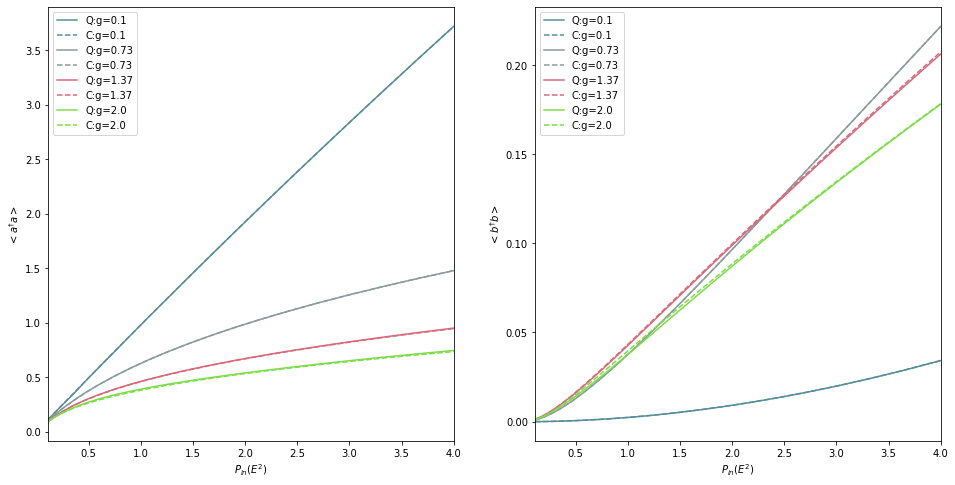

In [16]:
fig, axes = plt.subplots(1,2 , figsize=(16,8))
axes[0].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1]);axes[1].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1])
axes[0].set_xlabel(r'$P_{in}(E^2)$');axes[1].set_xlabel(r'$P_{in}(E^2)$')
for i in range(0,np.size(g_list)):
    cor=randomcolor()
    axes[0].plot(E_list*E_list,sol1[i,...,0],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,sol1[i,...,1],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
    axes[0].plot(E_list*E_list,sol2[i,...,0],color=cor,linestyle='--',label='C:g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,sol2[i,...,1],color=cor,linestyle='--',label='C:g='+str(round(g_list[i],2)))
axes[0].legend(loc=0); axes[1].legend(loc=0);
axes[0].set_ylabel(r'$<a^{\dagger}a>$')
axes[1].set_ylabel(r'$<b^{\dagger}b>$')    
print("qutip:"+str(t_qutip*1000)+'ms',end='\t')
print("QCLS:"+str(t_cluster*1000)+'ms')

Text(0, 0.5, 'Correlation b$g_{2}$')

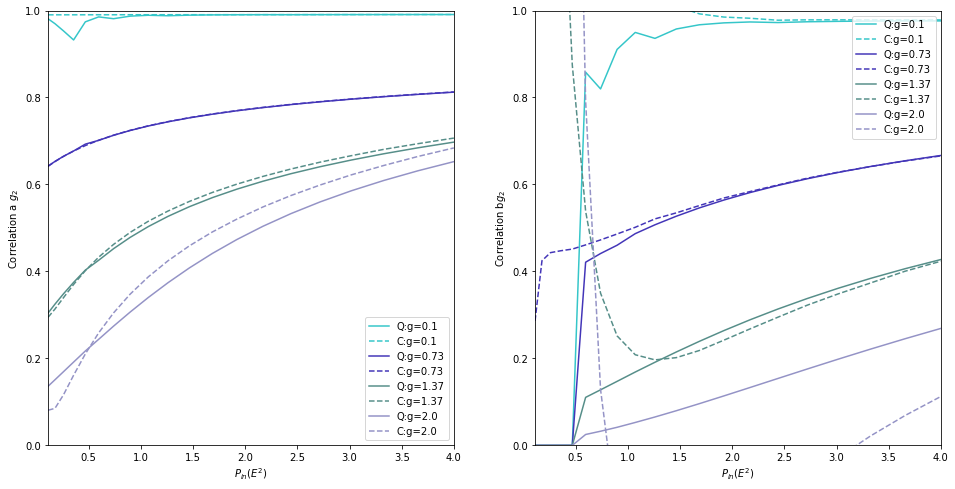

In [18]:
fig, axes = plt.subplots(1,2 , figsize=(16,8))
axes[0].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1]);axes[1].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1])
axes[0].set_ylim(0,1);axes[1].set_ylim(0,1)
axes[0].set_xlabel(r'$P_{in}(E^2)$');axes[1].set_xlabel(r'$P_{in}(E^2)$')
for i in range(0,np.size(g_list)):
    cor=randomcolor()
    axes[0].plot(E_list*E_list,sol1[i,...,2],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,sol1[i,...,3],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
    axes[0].plot(E_list*E_list,sol2[i,...,2],color=cor,linestyle='--',label='C:g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,sol2[i,...,3],color=cor,linestyle='--',label='C:g='+str(round(g_list[i],2)))
axes[0].legend(loc=0); axes[1].legend(loc=0);
axes[0].set_ylabel('Correlation a '+r'$g_{2}$')
axes[1].set_ylabel('Correlation b'+r'$g_{2}$')

Text(0, 0.5, 'Time QCLS t/s')

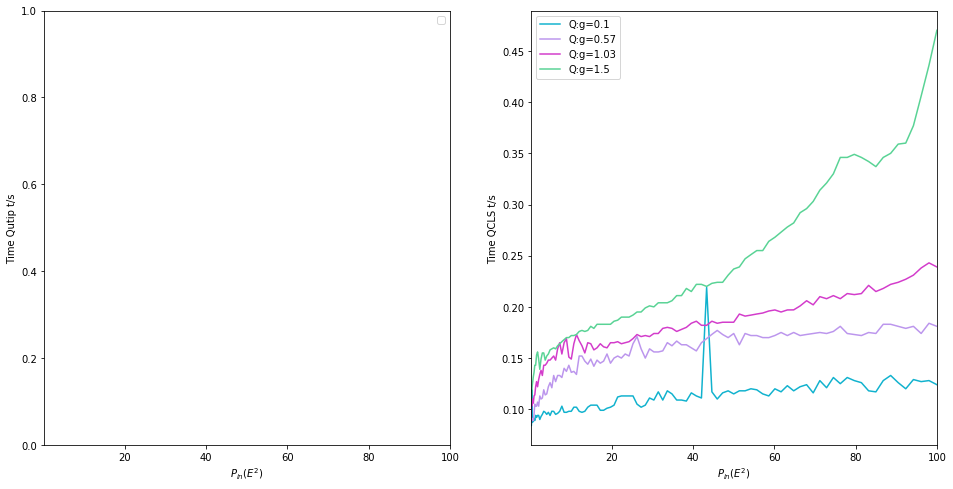

In [21]:
fig, axes = plt.subplots(1,2 , figsize=(16,8))
axes[0].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1]);axes[1].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1])
axes[0].set_xlabel(r'$P_{in}(E^2)$');axes[1].set_xlabel(r'$P_{in}(E^2)$')
for i in range(0,np.size(g_list)):
    cor=randomcolor()
    #axes[0].plot(E_list*E_list,sol1[i,...,4],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,sol2[i,...,4],color=cor,linestyle='-',label='Q:g='+str(round(g_list[i],2)))
axes[0].legend(loc=0); axes[1].legend(loc=0);
axes[0].set_ylabel('Time Qutip t/s')
axes[1].set_ylabel('Time QCLS t/s')

(6, 20) (6, 20)


Text(0, 0.5, 'Relative error')

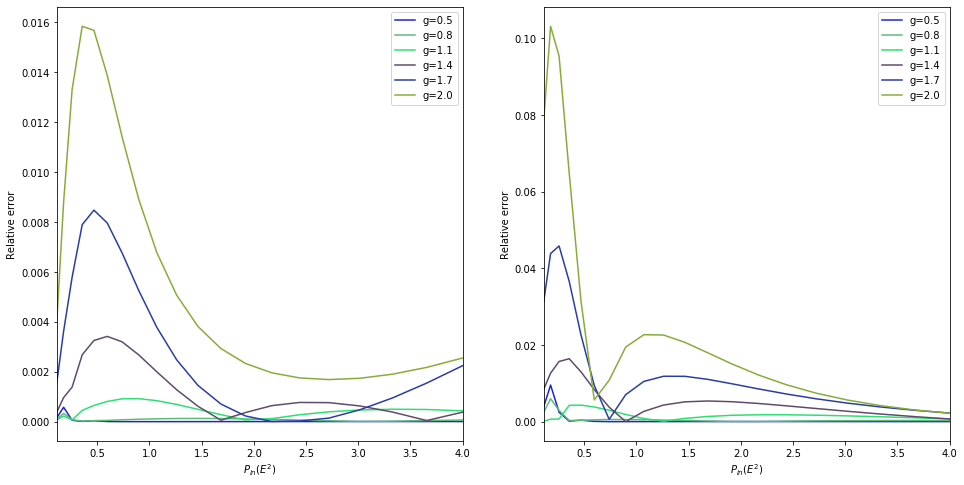

In [44]:
error_a=reError(sol1[...,0],sol2[...,0])
error_b=reError(sol1[...,1],sol2[...,1])
print(np.shape(error_a),np.shape(error_b))
fig, axes = plt.subplots(1,2 , figsize=(16,8))
axes[0].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1]);axes[1].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1])
axes[0].set_xlabel(r'$P_{in}(E^2)$');axes[1].set_xlabel(r'$P_{in}(E^2)$')
for i in range(0,np.size(g_list)):
    cor=randomcolor()
    axes[0].plot(E_list*E_list,error_a[i,...],color=cor,linestyle='-',label='g='+str(round(g_list[i],2)))
    axes[1].plot(E_list*E_list,error_b[i,...],color=cor,linestyle='-',label='g='+str(round(g_list[i],2)))
axes[0].legend(loc=0); axes[1].legend(loc=0);
axes[0].set_ylabel('Relative error')
axes[1].set_ylabel('Relative error')    

Text(0, 0.5, '$<b^{\\dagger}b>$')

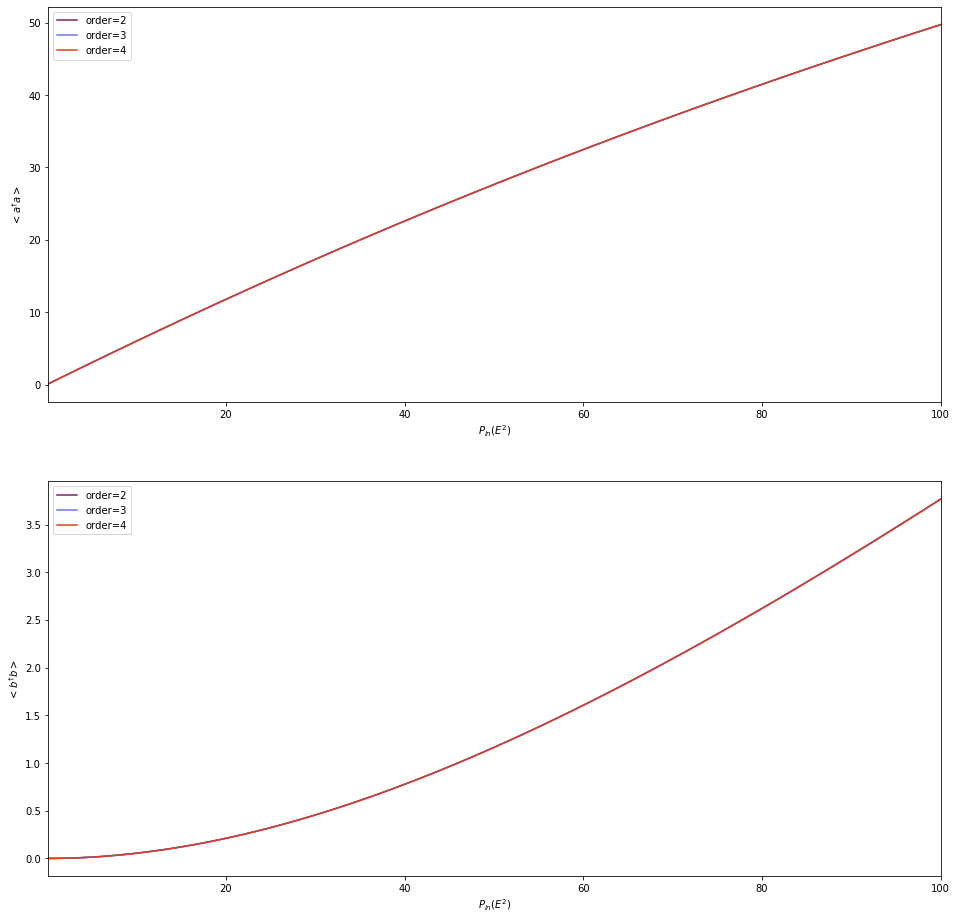

In [23]:
fig, axes = plt.subplots(2,1 , figsize=(16,16))
axes[0].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1]);axes[1].set_xlim(E_list[0]*E_list[0],E_list[-1]*E_list[-1])
axes[0].set_xlabel(r'$P_{in}(E^2)$');axes[1].set_xlabel(r'$P_{in}(E^2)$')
for i in range(0,3):
    cor=randomcolor()
    axes[0].plot(E_list*E_list,sol3[i,...,0],color=cor,linestyle='-',label='order='+str(i+2))
    axes[1].plot(E_list*E_list,sol3[i,...,1],color=cor,linestyle='-',label='order='+str(i+2))
axes[0].legend(loc=0); axes[1].legend(loc=0);
axes[0].set_ylabel(r'$<a^{\dagger}a>$')
axes[1].set_ylabel(r'$<b^{\dagger}b>$')    

### cluster test

In [10]:
H=[['AAAAAAA',1]]
T_o=['a']
data=QCLData.Data(H, [], T_o, 5)
data.Debug()

In [5]:
data.SetCurrentValue([1,1,1,1,1])

In [6]:
data.Calculate()

[-7j, 0j, 0j, 0j, 0j]

In [11]:
data.SetCurrentValue([-1j,1j,1j,1j,1j])

In [12]:
data.Calculate()

[(-1260-1673j), 0j, 0j, 0j, 0j]